In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import qinfer as qi

In [2]:
sys.path.append("/home/bf16951/QMD")
import qmla

# Quickly construct models and plot dynamics

[|++'> probes] Noise factor: 0
Model: pauliSet_1J2_xJx_d4+pauliSet_1J2_yJy_d4+pauliSet_1J2_zJz_d4+pauliSet_1J3_xJx_d4+pauliSet_1J3_yJy_d4+pauliSet_1J3_zJz_d4+pauliSet_1J4_xJx_d4+pauliSet_1J4_yJy_d4+pauliSet_1J4_zJz_d4+pauliSet_1_x_d4+pauliSet_1_y_d4+pauliSet_1_z_d4+pauliSet_2_x_d4+pauliSet_2_y_d4+pauliSet_2_z_d4+pauliSet_3_x_d4+pauliSet_3_y_d4+pauliSet_3_z_d4+pauliSet_4_x_d4+pauliSet_4_y_d4+pauliSet_4_z_d4


Text(0.5, 0, 'Time $s$')

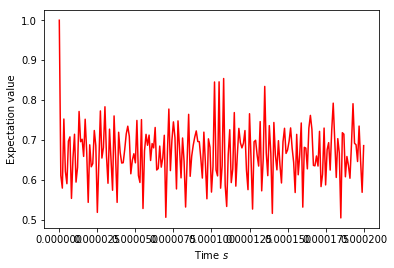

In [19]:
n_qubits = 4
true_model_terms_params = {
    # spin
    'pauliSet_1_x_d{}'.format(n_qubits) : 1.94e9,
    'pauliSet_1_y_d{}'.format(n_qubits) : 1.94e9,
    'pauliSet_1_z_d{}'.format(n_qubits) : 1.94e9,
    
    'pauliSet_1J2_zJz_d{}'.format(n_qubits) : 2.14e6, 
    'pauliSet_1J3_zJz_d{}'.format(n_qubits) : 2.4e6, 
    'pauliSet_1J4_zJz_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_zJz_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J6_zJz_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_yJy_d{}'.format(n_qubits) : 2.7e6, 
    'pauliSet_1J3_yJy_d{}'.format(n_qubits) : 2.4e6, 
    'pauliSet_1J4_yJy_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_yJy_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J6_yJy_d{}'.format(n_qubits) : 2.14e6, 

    'pauliSet_1J2_xJx_d{}'.format(n_qubits) : 2.7e6, 
    'pauliSet_1J3_xJx_d{}'.format(n_qubits) : 2.4e6, 
    'pauliSet_1J4_xJx_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J5_xJx_d{}'.format(n_qubits) : 2.14e6, 
#     'pauliSet_1J6_xJx_d{}'.format(n_qubits) : 2.14e6, 

    # nitrogen nuclei 
    'pauliSet_2_x_d{}'.format(n_qubits) : 3.37e9,
    'pauliSet_2_y_d{}'.format(n_qubits) : 3.37e9,
    'pauliSet_2_z_d{}'.format(n_qubits) : 3.37e9,

    # carbon nuclei - 3rd qubit
    'pauliSet_3_x_d{}'.format(n_qubits) : 117e3,
    'pauliSet_3_y_d{}'.format(n_qubits) : 117e3,
    'pauliSet_3_z_d{}'.format(n_qubits) : 117e3,

    # carbon nuclei - 4th qubit
    'pauliSet_4_x_d{}'.format(n_qubits) : 117e3,
    'pauliSet_4_y_d{}'.format(n_qubits) : 117e3,
    'pauliSet_4_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 5th qubit
#     'pauliSet_5_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_5_z_d{}'.format(n_qubits) : 117e3,

#     # carbon nuclei - 6th qubit
#     'pauliSet_6_x_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_y_d{}'.format(n_qubits) : 117e3,
#     'pauliSet_6_z_d{}'.format(n_qubits) : 117e3,
}

true_model = '+'.join(
    (true_model_terms_params.keys())
)
true_model = qmla.construct_models.alph(true_model)

# Construct Hamiltonian
hamiltonian = None
for k in true_model_terms_params:
    
    param = true_model_terms_params[k]
    mtx = qmla.construct_models.compute(k)
    
    if hamiltonian is None: 
        hamiltonian = param * mtx
    else:
        hamiltonian += param * mtx

# Configuration        
num_qubits = int(np.log2(np.shape(hamiltonian))[0])
probe_set = qmla.shared_functionality.probe_set_generation.plus_plus_with_phase_difference(
    num_probes=1, 
    max_num_qubits=num_qubits,
    noise_level=0
)
probe = probe_set[(0,num_qubits)]

max_time = 200e-6
time_increment = 1e-6
times = np.arange(0, max_time, time_increment)

# Compute expectation values
expectation_values = {
    t : qmla.shared_functionality.n_qubit_hahn_evolution(
        ham = hamiltonian, 
        t = t,
        state = probe
    )
    for t in times
}
ex_val_list = [expectation_values[t] for t in times]

# Plot results
print("Model:", true_model)
plt.plot(
    times,
    ex_val_list, 
    color='red',
    ms = 40, 
    markevery=10
)

plt.figsize=(15, 10)
plt.ylabel('Expectation value')
plt.xlabel('Time $s$')

In [14]:
%matplotlib inline